# Contraction

```{hint}
This page describes the low level contraction functionality of `cotengra`, see
the [high level interface functions](high-level-interface) for standard use.
```

You can pass the `cotengra` optimizers, or
[paths](cotengra.ContractionTree.get_path)
generated with them, to
[`quimb`](https://quimb.readthedocs.io/en/latest/),
[`opt_einsum`](https://dgasmith.github.io/opt_einsum/),
and other libraries (generally via the `optimize=` kwarg), but `cotengra` also
provides its own contraction functionality encapsulated in the
[`ContractionTree.contract`](cotengra.ContractionTree.contract) method.

For an example let's generate a square lattice contraction:

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import cotengra as ctg

inputs, output, shapes, size_dict = ctg.utils.lattice_equation([10, 10])
arrays = [np.random.uniform(size=shape) for shape in shapes]

Then find a high quality tree for it (using `minimize='combo'` is generally
good for real world contraction performance):

In [2]:
opt = ctg.HyperOptimizer(
    minimize="combo",
    reconf_opts={},
    progbar=True,
)
tree = opt.search(inputs, output, size_dict)

log2[SIZE]: 10.00 log10[FLOPs]: 5.28: 100%|██████████| 128/128 [00:04<00:00, 28.46it/s]


We can have a quick look at the tree:

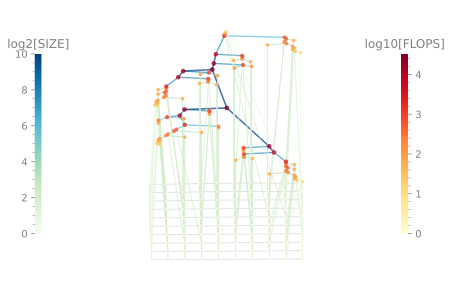

(<Figure size 500x500 with 3 Axes>, <Axes: >)

In [3]:
tree.plot_tent(order=True)

## Basic contraction

Contracting is then as simple as:

In [4]:
tree.contract(arrays)

array(8.02217303e+22)

We can also show live progress for feedback with `progbar=True`.
And if the value of contraction is going to be very large or small (e.g. some
weighted counting problems), then setting `strip_exponents=True` will actively
rescale intermediate tensors and return the result as a scaled output array
(the 'mantissa') and the exponent separately:

In [5]:
tree.contract(arrays, progbar=True, strip_exponent=True)

100%|██████████| 99/99 [00:00<00:00, 16029.81it/s]


(1.0, 22.904292025082466)

such that the full output would be `mantissa * 10**exponent`.

## Sliced contraction

One of the main reasons to use the contraction abilities of `cotengra` is that
it handles sliced contractions. Let's generate a sliced tree with a minimum
of 32 slices:

In [6]:
opt = ctg.HyperOptimizer(
    minimize="combo",
    slicing_opts={"target_slices": 32},
    reconf_opts={},
    progbar=True,
)
tree = opt.search(inputs, output, size_dict)

log2[SIZE]: 8.00 log10[FLOPs]: 5.91: 100%|██████████| 128/128 [00:04<00:00, 25.76it/s]


The sliced indices appear as dashed lines if we plot the tree:

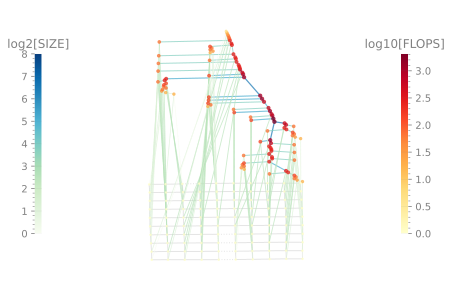

(<Figure size 500x500 with 3 Axes>, <Axes: >)

In [7]:
tree.plot_tent(order=True)

In [8]:
tree.sliced_inds, tree.nslices

({'ä': SliceInfo(inner=True, ind='ä', size=2, project=None),
  'æ': SliceInfo(inner=True, ind='æ', size=2, project=None),
  'è': SliceInfo(inner=True, ind='è', size=2, project=None),
  'ê': SliceInfo(inner=True, ind='ê', size=2, project=None),
  'þ': SliceInfo(inner=True, ind='þ', size=2, project=None)},
 32)

### Automated

`cotengra` can perform all of the necessary slicing and summing in the
background for you just by calling the `ContractionTree.contract` method as
usual:

In [9]:
tree.contract(arrays, progbar=True)

100%|██████████| 32/32 [00:00<00:00, 489.62it/s]


8.022173030954557e+22

If you are just interested in the memory savings of slicing then this is
usually sufficient.

```{note}
* For sliced trees progress is shown across slices, not individual contractions.
* You can still set `strip_exponents=True` - but be aware the
overall exponent is fixed by the first slice contracted.
```

### Manual

To control for example parallelization you have to take a slightly more
hands-on approach using the some combination of the following methods:

* [`ContractionTree.slice_arrays`](cotengra.ContractionTree.slice_arrays) -
  slice the arrays for slice number `i`
* [`ContractionTree.contract_core`](cotengra.ContractionTree.contract_core) -
  contract a single set of already sliced arrays, e.g. from above function
* [`ContractionTree.contract_slice`](cotengra.ContractionTree.contract_slice) -
  contract slice `i`, this simply combines the above two functions
* [`ContractionTree.gather_slices`](cotengra.ContractionTree.gather_slices) -
  gather all the separate sliced outputs and combine into the full output

The slices are enumerated by `range(tree.nslices)`. The following demonstrates
an explicit loop that you could distribute:

In [10]:
# note this can be a lazy generator
output_slices = (tree.contract_slice(arrays, i) for i in range(tree.nslices))

tree.gather_slices(output_slices)

8.022173030954557e+22

There are more examples in the `examples` folder, demonstrating using:

* an executor pool
* GPU
* MPI

If no sliced indices are in the output then the final gather is just a sum,
however if this isn't the case then the final gather also involves calls to
`stack`. If you are just interested in iterating over the output slices (for
example performing a map-reduce like $\sum f(T)$) then you can do so lazily with
[ContractionTree.gen_output_chunks](cotengra.ContractionTree.gen_output_chunks)
which avoids constructing the full output tensor.

## Backends and `autoray`

`cotengra` dispatches the functions
[`tensordot`](https://numpy.org/doc/stable/reference/generated/numpy.tensordot.html),
[`einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html),
[`transpose`](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html)
and
[`stack`](https://numpy.org/doc/stable/reference/generated/numpy.stack.html)
using [`autoray`](https://github.com/jcmgray/autoray) thereby
supporting a wide range of backend tensor libraries, as well as functionality
like **intermediate reuse**, **lazy tracing**, and **compilation**. This
usually requires no extra input:

In [11]:
import cupy as cp

gpu_arrays = [cp.asarray(array) for array in arrays]
tree.contract(gpu_arrays)

array(8.0221730e+22)

but you can specify the `backend` kwarg to explicitly control which module to
lookup the functions from, or directly register your own implementations with
`autoray`.

### `prefer_einsum`

If you would like to use `einsum` for every contraction, not just those that
`tensordot` doesn't support, then set `prefer_einsum=True`.


### `autojit`

This is an experimental feature of `autoray` that tries to just in time compile
and then cache the contraction expression based on the backend. For `numpy` and
`cupy` for example, this just strips away some python scaffold and offers a
small speedup if a contraction will be called many times. For `jax` and others
it makes use of their full compilation abilities.

## Differences with opt_einsum

The major difference between contraction in `cotengra` and `opt_einsum` is just
that `cotengra` handles slicing. There are also a few other minor differences
between the two:

* `opt_einsum` prefers to use `einsum` (if available) for *some* operations that
  `tensordot` could be used for (e.g. outer products), `cotengra` prefers
  `tensordot` for all operations that are possible with it
* cotengra uses [`autoray`](https://github.com/jcmgray/autoray) to dispatch
  pairwise `tensordot`, `transpose` and `einsum` operations
* the costs `opt_einsum` reports assumes a real datatype for the tensors, which
  is generally twice as high compared to generic 'ops' (i.e.
  [`tree.contraction_cost()`](cotengra.ContractionTree.contraction_cost))
  and four times lower than assuming a complex datatype (i.e.
  [`tree.total_flops('complex')`](cotengra.ContractionTree.total_flops)).